In [1]:
!git clone https://github.com/leoimpett/PyRetri-Colab &>/dev/null
%cd /content/PyRetri-Colab/
!pip install -r requirements.txt  &>/dev/null
!python  setup.py install &>/dev/null




import json
import requests
import tqdm
import multiprocessing

!mkdir ycba_images
!mkdir ycba_images/imgs

with open("/content/ycbaprints.json", "r") as myfile:
    data = json.load(myfile)
    

imkeys = []
imURLs = {}
imtitles = {}

for item in data["results"]["result"]:
    thiskey = item["binding"][2]["uri"]
    if thiskey not in imkeys:
        imkeys.append(thiskey)
        imURLs[thiskey] = item["binding"][1]["uri"]
        imtitles[thiskey] = item["binding"][0]["literal"]
        
def makeFilePath(imkey):
    endkey = imkey.split("/")[-1]
    return "ycba_images/imgs/" + endkey + ".jpg"


def downloadImage(thiskey):
    url = imURLs[thiskey]
    response = requests.get(url)
    if response.status_code == 200:
        with open( makeFilePath(thiskey) , 'wb') as f:
            f.write(response.content)
    return 0


pool = multiprocessing.Pool(16)

_ = pool.map(downloadImage, imkeys)


/content/PyRetri-Colab
--2020-10-31 17:49:59--  https://raw.githubusercontent.com/leoimpett/PyRetri-Colab/master/ycbaprints.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12405457 (12M) [text/plain]
Saving to: ‘ycbaprints.json.1’

ycbaprints.json.1   100%[===================>]  11.83M  33.9MB/s    in 0.3s    

2020-10-31 17:50:00 (33.9 MB/s) - ‘ycbaprints.json.1’ saved [12405457/12405457]



# Extract features from the Gallery

In [ ]:
images_data_path = "/content/drive/My Drive/1625/"
test_im = '/content/drive/My Drive/1625/imgs/VM156_2RES.jpg'


from matplotlib import pyplot as plt
from skimage import io
import tqdm
import glob
import os

import torch

from pyretri.config import get_defaults_cfg, setup_cfg
from pyretri.datasets import build_folder, build_loader
from pyretri.models import build_model
from pyretri.extract import build_extract_helper

from torchvision import models

from pyretri.extract import make_data_json

make_data_json(images_data_path,"./data_jsons/gdrive.json","general")

# init and load retrieval pipeline settings
cfg = get_defaults_cfg()
cfg = setup_cfg(cfg, "configs/gdrive.yaml", [])

# build dataset and dataloader
dataset = build_folder("./data_jsons/gdrive.json", cfg.datasets)
dataloader = build_loader(dataset, cfg.datasets)

# build model
model = build_model(cfg.model)

# build helper and extract features
extract_helper = build_extract_helper(model, cfg.extract)
extract_helper.do_extract(dataloader, "./data/features/gdrive", save_interval=5000)




mkdir: cannot create directory ‘data_jsons’: File exists


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


 60%|█████▉    | 28/47 [01:02<00:29,  1.57s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (109235200 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
100%|██████████| 47/47 [01:56<00:00,  2.47s/it]


time:  116.52027797698975


# Now extract them from a test image

In [ ]:
!mkdir retrieved_images
!rm retrieved_images/*

import os
from PIL import Image
import numpy as np

from pyretri.config import get_defaults_cfg, setup_cfg
from pyretri.datasets import build_transformers
from pyretri.models import build_model
from pyretri.extract import build_extract_helper
from pyretri.index import build_index_helper, feature_loader



config_file = "configs/gdrive.yaml"


# init and load retrieval pipeline settings
cfg = get_defaults_cfg()
cfg = setup_cfg(cfg, config_file, [])

# set path for single image
path = test_im

# build transformers
transformers = build_transformers(cfg.datasets.transformers)

# build model
model = build_model(cfg.model)

# read image and convert it to tensor
img = Image.open(path).convert("RGB")
img_tensor = transformers(img)

# build helper and extract feature for single image
extract_helper = build_extract_helper(model, cfg.extract)
img_fea_info = extract_helper.do_single_extract(img_tensor)
stacked_feature = list()
for name in cfg.index.feature_names:
    assert name in img_fea_info[0], "invalid feature name: {} not in {}!".format(name, img_fea_info[0].keys())
    stacked_feature.append(img_fea_info[0][name].cpu())
img_fea = np.concatenate(stacked_feature, axis=1)

# load gallery features
gallery_fea, gallery_info, _ = feature_loader.load(cfg.index.gallery_fea_dir, cfg.index.feature_names)

# build helper and single index feature
index_helper = build_index_helper(cfg.index)


#index_result_info, query_fea, gallery_fea = index_helper.do_index(img_fea, img_fea_info, gallery_fea)

#index_helper.save_topk_retrieved_images('retrieved_images/', index_result_info[0], 5, gallery_info)

#print('single index have done!')



mkdir: cannot create directory ‘retrieved_images’: File exists
rm: cannot remove 'retrieved_images/*': No such file or directory
[LoadFeature] Success, total 745 images, 
 feature names: dict_keys(['pool5_GeM'])
[LoadFeature] Success, total 745 images, 
 feature names: dict_keys(['pool5_GeM'])


In [ ]:
index_result_info, query_fea, gallery_fea = index_helper.do_index(gallery_fea, gallery_info, gallery_fea)



In [ ]:
print(index_result_info[0]["ranked_neighbors_idx"])
print(len(index_result_info[0]["ranked_neighbors_idx"]))
print(len(index_result_info))


[0, 520, 148, 555, 596, 68, 493, 347, 101, 503, 1, 144, 329, 459, 657, 155, 483, 600, 697, 242, 102, 366, 701, 79, 590, 267, 60, 237, 27, 450, 337, 168, 44, 479, 593, 696, 50, 45, 196, 718, 336, 15, 595, 246, 23, 384, 410, 22, 692, 614, 691, 472, 598, 693, 308, 712, 171, 284, 571, 705, 56, 716, 310, 192, 106, 356, 698, 733, 118, 623, 677, 636, 33, 17, 16, 248, 700, 49, 40, 631, 695, 153, 717, 195, 558, 178, 66, 174, 416, 545, 31, 43, 498, 76, 233, 679, 132, 515, 425, 674, 270, 292, 152, 681, 680, 591, 321, 556, 119, 576, 42, 258, 599, 220, 641, 273, 136, 190, 714, 241, 699, 207, 653, 182, 554, 727, 465, 540, 516, 367, 226, 107, 704, 141, 100, 146, 690, 10, 387, 342, 568, 62, 96, 394, 370, 686, 689, 287, 440, 682, 219, 357, 583, 198, 94, 463, 411, 231, 89, 546, 597, 88, 109, 376, 85, 449, 105, 713, 602, 405, 214, 315, 150, 373, 319, 54, 13, 624, 58, 340, 95, 140, 145, 676, 249, 14, 67, 98, 91, 134, 99, 382, 18, 189, 487, 239, 629, 461, 706, 467, 526, 21, 637, 338, 584, 398, 423, 548, 72

In [ ]:
import json

!rm jsonfiles/*
!mkdir jsonfiles

for element in gallery_info:
  elidx = element["idx"]
  filep = element["path"]
  filen = filep.split("/")[-1].split(".")[0]
  nearest = element["ranked_neighbors_idx"]
  
  nearData = []
  for jdx in nearest:
    nearData.append({"filename":gallery_info[jdx]["path"].split("/")[-1].split(".")[0],"similarity":1.0,"caption":"Test"})

  jsonfn = "jsonfiles/" + filen + ".json"
  with open(jsonfn, "w") as jfile:
    json.dump(nearData,jfile)


presentData = []
for element in gallery_info:
  presentData.append({"image":element["path"].split("/")[-1],"caption":"Test"})

print(len(presentData))
with open("randomImagePaths.json", "w") as jfile:
  json.dump(presentData,jfile)


!zip -r jsonfiles.zip jsonfiles

rm: cannot remove 'jsonfiles': Is a directory
mkdir: cannot create directory ‘jsonfiles’: File exists


In [2]:
plt.imshow(io.imread(test_im))

NameError: ignored

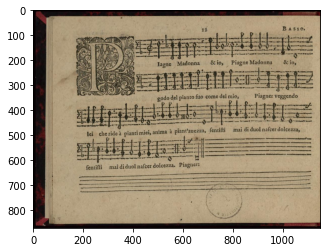

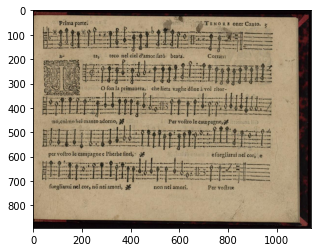

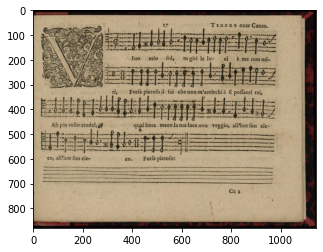

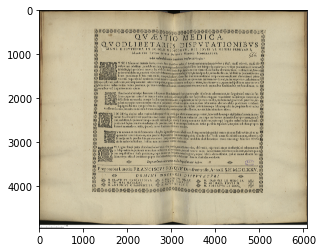

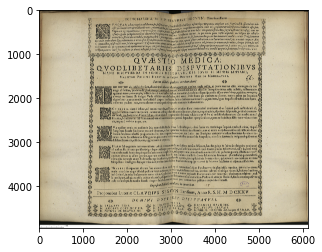

In [ ]:
imlist = glob.glob("./retrieved_images/*")
for iml in imlist:
  plt.figure()
  plt.imshow(io.imread(iml))